首先说明一下，这一节其实与EM没多大关系，只是想对GMM的分类作一个实现并推导它与LogisticRegression之间的关系
### 一.分类原理
分类实现的原理非常简单，对每一个类训练一个高斯模型模型（如果你喜欢，多个也是可以的，这里你就可以使用用EM算法了，将前面的GMMCluster简单封装一下就可以）即可，然后每个类的权重由其样本所占比例确定

In [5]:
import os
os.chdir('../')
import numpy as np
%matplotlib inline
from ml_models.em import GMMCluster

"""
利用GMMCluster实现分类，代码封装到ml_models.em
"""

class GMMClassifier(object):
    def __init__(self, cluster_each_class=1, n_iter=100, tol=1e-3, shr_cov=False):
        """
        :param cluster_each_class:每个类需要几个高斯模型去拟合，默认1个
        :param n_iter:迭代次数
        :param tol: -log likehold增益<tol时，停止训练
        :param shr_cov:是否共享协方差矩阵
        """
        self.cluster_each_class = cluster_each_class
        self.n_iter = n_iter
        self.tol = tol
        self.shr_cov = shr_cov
        self.models = []

    def fit(self, X, y):
        for y_index in range(y.max() + 1):
            new_X = X[y == y_index]
            cluster = GMMCluster(n_components=self.cluster_each_class, tol=self.tol, n_iter=self.n_iter)
            cluster.fit(new_X)
            self.models.append(cluster)
        if self.shr_cov:
            # 获取所有的协方差矩阵
            sigmas = []
            for model in self.models:
                params = model.params
                for param in params:
                    sigmas.append(param[2])
            # 求平均
            ave_sigma = np.mean(sigmas, axis=0)
            # 更新
            for model in self.models:
                params = model.params
                for param in params:
                    param[2] = ave_sigma

    def predict_proba(self, X):
        W = np.asarray([model.predict_sample_generate_proba(X) for model in self.models]).T
        W = W / np.sum(W, axis=1, keepdims=True)
        return W

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

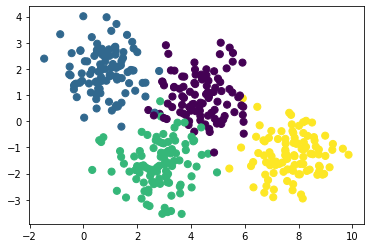

In [10]:
#造数据
from sklearn.datasets.samples_generator import make_blobs
from ml_models import utils
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.85, random_state=0)
X = X[:, ::-1]
plt.scatter(X[:,0],X[:,1],c=y,s=50)

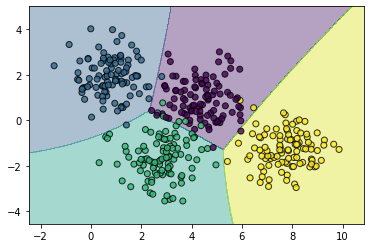

In [7]:
#训练模型并可视化
gmm = GMMClassifier(n_iter=100)
gmm.fit(X, y)
utils.plot_decision_function(X, y, gmm)

代码里面添加了一个`shr_cov`的超参，如果`shr_cov=True`表示所有的模型都会共享同一个协方差矩阵，我们接下来看看会发生什么

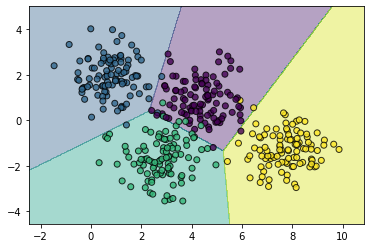

In [8]:
gmm = GMMClassifier(n_iter=100,shr_cov=True)
gmm.fit(X, y)
utils.plot_decision_function(X, y, gmm)

可以发现类与类的边界都变成了**直线**，这时的GMM模型似乎退化成了一个线性模型，这是为什么呢？它这时其实是一个带有一定约束的LogisticRegression模型，接下来我们推推看它们之间的关系

### 二.协方差矩阵共享的GMM模型与LogisticRegression的关系
以二分类为例进行推导，假如我们训练好了两个分类模型，分别为$C_1,C_2$，那么有：   

$$
p(x\mid C_1)=N(x\mid u_1,\Sigma)\\
p(x\mid C_2)=N(x\mid u_2,\Sigma)\\
p(C_1)+p(C_2)=1
$$   
所以，高斯混合模型：   

$$
p(x)=p(C_1)p(x\mid C_1)+p(C_2)p(x\mid C_2)
$$  

接下来，我们转换为判断模型的形式：   

$$
p(C_1\mid x)=\frac{p(C_1)p(x\mid C_1)}{p(x)}\\
=\frac{p(C_1)p(x\mid C_1)}{p(C_1)p(x\mid C_1)+p(C_2)p(x\mid C_2)}\\
=\frac{1}{1+exp(-Z)}
$$   

这里$Z=log\frac{p(C_1)p(x\mid C_1)}{p(C_2)p(x\mid C_2)}$，这里已经看到了LogisticRegression的雏形了，接着，我们将$Z$化简看看：  

$$
Z=log\frac{p(C_1)p(x\mid C_1)}{p(C_2)p(x\mid C_2)}\\
=log\frac{p(x\mid C_1)}{p(x\mid C_2)}+log\frac{p(C_1)}{p(C_2)}\\
=....省略....\\
=(u_1-u_2)^T\Sigma^{-1}x-\frac{1}{2}u_1^T\Sigma^{-1}u_1+\frac{1}{2}u_2^T\Sigma^{-1}u_2+log\frac{N_1}{N_2}(N_1,N_2表示1,2类的样本量\frac{p(C_1)}{p(C_2)}=\frac{N_1}{N_2})
$$  

所以，如果令：  
$$
w^T=(u_1-u_2)^T\Sigma^{-1}\\
b=-\frac{1}{2}u_1^T\Sigma^{-1}u_1+\frac{1}{2}u_2^T\Sigma^{-1}u_2+log\frac{N_1}{N_2}
$$  

那么：  

$$
Z=w^Tx+b
$$  

那么：  

$$
p(C_1\mid x)=\frac{1}{1+exp(-w^Tx-b)}
$$  

所以，如果数据量大没必要去训练一个复杂的GMM分类器，就训练一个LR就好啦...